# Stat Analysis

In [1]:
import pandas as pd
import os
import numpy as np 
import statsmodels.formula.api as smf
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as st 

In [2]:
# read in combined dataframe
combo_df = pd.read_csv("combined_df.txt")

# rename first column to name of benchmarks 
combo_df.rename(columns={'Unnamed: 0':'Benchmark'}, inplace=True)

# drop informational messages
combo_df = combo_df.drop(['I'], axis=1)

# drop fatal error messages
combo_df = combo_df.drop(['F'], axis=1)

# turn Nan to zero
combo_df = combo_df.fillna(0)

# print first few lines of dataframe 
combo_df.head()

# combine high and medium severity counts into one category
combo_df['BANDIT_MED_HIGH'] = combo_df['TOTAL_BANDIT'].subtract(combo_df['LOW_SEVERITY'])

# Step 1: Overview of data
- i) Distribution of Pylint types of errors
- ii) Distribution of types of security vulnerabilities
- iii) Distribution of security vulnerabilties by severity 

## i. Distribution of Pylint types of errors

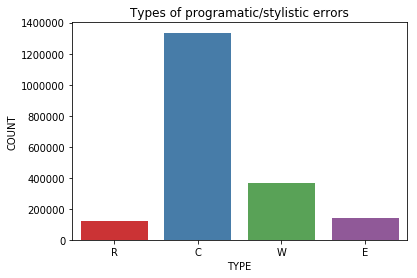

In [3]:
sum_col = combo_df.apply('sum')
pylint_count = sum_col.filter(items=['I', 'R','C','W','E','F'])
pylint_count_df = pd.DataFrame({'TYPE': pylint_count.index, 'COUNT': pylint_count})

g = sns.barplot(x="TYPE", y="COUNT", data=pylint_count_df, palette='Set1')
plt.title("Types of programatic/stylistic errors")
plt.show()
plt.close()

## ii) Distribution of types of security vulnerabilities

In [4]:
# List of bandit tests from https://github.com/PyCQA/bandit
test_ids = ["B101", "B102", "B103", "B104", "B105", "B106", "B107", "B108", "B109", "B110", "B111", "B112"]
test_ids += ["B201"]
test_ids += ["B301", "B302", "B303", "B304", "B305", "B306", "B307", "B308", "B309", "B310"]
test_ids += ["B311", "B312", "B313", "B314", "B315", "B316", "B317", "B318", "B319", "B320"]
test_ids += ["B321", "B322", "B323", "B324", "B325"]
test_ids += ["B401", "B402", "B403", "B404", "B405", "B406", "B407", "B408", "B409", "B410", "B411", "B412", "B413"]
test_ids += ["B501", "B502", "B503", "B504", "B505", "B506", "B507"]
test_ids += ["B601", "B602", "B603", "B604", "B605", "B606", "B607", "B608", "B609", "B610", "B611"]
test_ids += ["B701", "B702", "B703"]

sum_col = combo_df.apply('sum')
bandit_count = sum_col.filter(items=test_ids)
bandit_count_df = pd.DataFrame({'TYPE': bandit_count.index, 'COUNT': bandit_count})

#g = sns.barplot(x="TYPE", y="COUNT", data=bandit_count_df, palette='Set1')
#plt.title("Types of security vulnerabilities")

## Top 10 types of security vulneratbilities

In [5]:
sorted_bandit_count = bandit_count.sort_values(ascending=False)
sorted_bandit_count[:10]

# assert used
# try_except_pass
# subprocess_without_shell_equals_true
# hardcoded_password_string
# hardcoded_password_funcarg
# random
# import_pycrypto
# hardcoded_tmp_directory
# import_subprocess
# md5

B101    53390
B110     1074
B603     1054
B105      915
B106      852
B311      803
B413      782
B108      653
B404      590
B303      507
dtype: object

In [6]:
# which programs had most high severity issues
high_severity_bandit_df = combo_df.sort_values(by='HIGH_SEVERITY', ascending=False)
#print(high_severity_bandit_df['Benchmark'][:10])

# top 10 normalized by benchmark size 
high_severity_bandit_df['HIGH_SEVERITY_NORM'] = high_severity_bandit_df['HIGH_SEVERITY'].divide(high_severity_bandit_df['BENCHMARK_SIZE'])
high_severity_bandit_df = high_severity_bandit_df.sort_values(by='HIGH_SEVERITY_NORM', ascending=False)
print(high_severity_bandit_df['Benchmark'][:10])

# --> be careful using any types of security, crypto, networking-related libraries 

443          pycrypto-2.5
29           Jinja2-2.7.1
446       pyftpdlib-0.2.0
473     python-jose-1.3.1
437     pyXMLSecurity-0.8
531             tmc-0.3.4
444    pycryptodome-3.6.5
58             Pyro4-4.71
488           rauth-0.6.2
112         bakercm-0.4.3
Name: Benchmark, dtype: object


# iii) Distribution of security vulnerabilties by severity

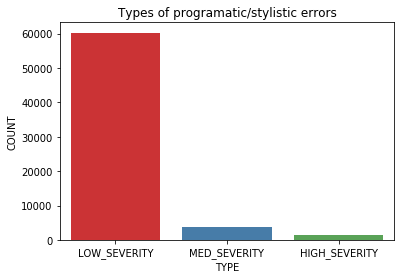

In [7]:
sum_col = combo_df.apply('sum')
pylint_count = sum_col.filter(items=['LOW_SEVERITY', 'MED_SEVERITY', 'HIGH_SEVERITY'])
pylint_count_df = pd.DataFrame({'TYPE': pylint_count.index, 'COUNT': pylint_count})

g = sns.barplot(x="TYPE", y="COUNT", data=pylint_count_df, palette='Set1')
plt.title("Types of programatic/stylistic errors")
plt.show()
plt.close()

# Step 2: Relationship between total errors and total vulnerabilities
- i) vanilla linear regression
- ii) multivariate regression by type of error
- iii) regression by severity 
- iv) different types of severity driven by types of errors
- v) looking into outliers

### i) univariate relationship between total pylint errors and total bandit errors

r^2: 0.04609 (2.706e-07)
correlation: 0.2147 (2.706e-07)


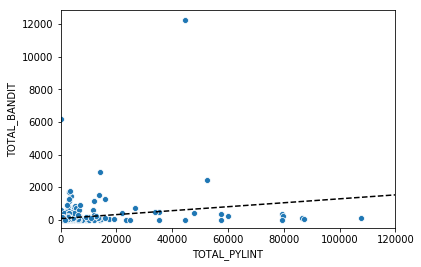

In [8]:
slope, intercept, r_square, p_value, std_err = st.linregress(x=combo_df['TOTAL_PYLINT'].values, y=combo_df['TOTAL_BANDIT'].values)
x = np.arange(1,150000)
y = slope*x+intercept

model = smf.ols('TOTAL_BANDIT ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()

r_square = model.rsquared
p_value = model.f_pvalue

corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['TOTAL_BANDIT'].values)

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

sns.scatterplot(x='TOTAL_PYLINT', y='TOTAL_BANDIT', data=combo_df, palette='Set1')
plt.plot(x, y, linestyle='--', color='black')
plt.ylim(-500.0)
plt.xlim(0, 120000)
plt.show()

## ii) multivariate regression of total bandit errors by type of pylint error

In [10]:
model = smf.ols('TOTAL_BANDIT ~ R + C + W + E', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

                            OLS Regression Results                            
Dep. Variable:           TOTAL_BANDIT   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     42.92
Date:                Sat, 08 Jun 2019   Prob (F-statistic):           2.11e-31
Time:                        23:10:59   Log-Likelihood:                -4351.5
No. Observations:                 563   AIC:                             8713.
Df Residuals:                     558   BIC:                             8735.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.2383     24.686      1.954      0.0

## iii) univariate analysis of total pylint errors versus high, med, low severity issues

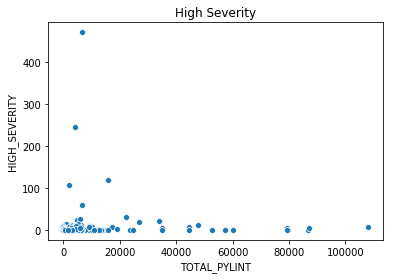

r^2: 0.00237 (0.2488)
correlation: 0.04868 (0.2488)


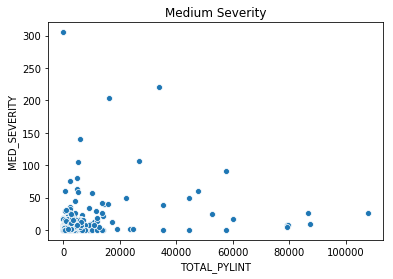

r^2: 0.05975 (4.197e-09)
correlation: 0.2444 (4.197e-09)


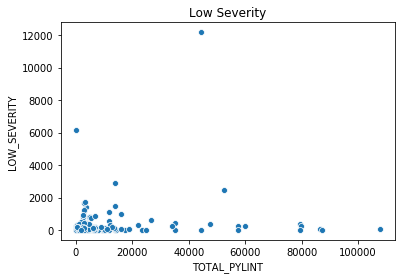

r^2: 0.04247 (8.133e-07)
correlation: 0.2061 (8.133e-07)


In [13]:
model = smf.ols('HIGH_SEVERITY ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='TOTAL_PYLINT', y='HIGH_SEVERITY', data=combo_df, palette='Set1')
plt.title("High Severity")
plt.show()
plt.close()
corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['HIGH_SEVERITY'].values)

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

model = smf.ols('MED_SEVERITY ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='TOTAL_PYLINT', y='MED_SEVERITY', data=combo_df, palette='Set1')
plt.title("Medium Severity")
plt.show()
plt.close()

corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['MED_SEVERITY'].values)
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))

model = smf.ols('LOW_SEVERITY ~ TOTAL_PYLINT', data=combo_df).fit()
summary = model.summary()
#print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
sns.scatterplot(x='TOTAL_PYLINT', y='LOW_SEVERITY', data=combo_df, palette='Set1')
plt.title("Low Severity")
plt.show()
plt.close()
corr_coef, rho_pvalue = st.pearsonr(combo_df['TOTAL_PYLINT'].values, combo_df['LOW_SEVERITY'].values)
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print("correlation: %.4g (%.4g)" % (corr_coef, rho_pvalue))



## iv) severity of vulnerabilities driven by different types of pylint errors 

In [12]:
model = smf.ols('HIGH_SEVERITY ~ R + C + W + E', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

model = smf.ols('MED_SEVERITY ~  R + C + W + E ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

model = smf.ols('LOW_SEVERITY ~ R + C + W + E ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues
print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)


                            OLS Regression Results                            
Dep. Variable:          HIGH_SEVERITY   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4758
Date:                Sat, 08 Jun 2019   Prob (F-statistic):              0.753
Time:                        23:12:49   Log-Likelihood:                -2575.7
No. Observations:                 563   AIC:                             5161.
Df Residuals:                     558   BIC:                             5183.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2951      1.054      2.179      0.0

## v) take into account benchmark size

In [16]:
results = smf.ols('TOTAL_BANDIT ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])

residual = combo_df['TOTAL_BANDIT'].values - Y_pred
combo_df['RESIDUAL'] = residual

results = smf.ols('R ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
R_residual = combo_df['R'].values - Y_pred
combo_df['R_RESIDUAL'] = R_residual

results = smf.ols('C ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
C_residual = combo_df['C'].values - Y_pred
combo_df['C_RESIDUAL'] = C_residual

results = smf.ols('W ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
W_residual = combo_df['W'].values - Y_pred
combo_df['W_RESIDUAL'] = W_residual

results = smf.ols('E ~ BENCHMARK_SIZE', data=combo_df).fit()
Y_pred = results.predict(combo_df['BENCHMARK_SIZE'])
E_residual = combo_df['E'].values - Y_pred
combo_df['E_RESIDUAL'] = E_residual

#model = smf.ols('TOTAL_BANDIT ~ R + C + W + E ', data=combo_df).fit()
#model = smf.ols('TOTAL_BANDIT ~ R + C + W + E + BENCHMARK_SIZE', data=combo_df).fit()
model = smf.ols('RESIDUAL ~ R_RESIDUAL + C_RESIDUAL + W_RESIDUAL + E_RESIDUAL ', data=combo_df).fit()
summary = model.summary()
print(summary)
r_square = model.rsquared
p_value = model.f_pvalue
t_pvalues = model.pvalues

print("r^2: %.4g (%.4g)" % (r_square, p_value))
print(t_pvalues)

                            OLS Regression Results                            
Dep. Variable:               RESIDUAL   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     33.31
Date:                Sat, 08 Jun 2019   Prob (F-statistic):           6.16e-25
Time:                        23:16:19   Log-Likelihood:                -4334.9
No. Observations:                 563   AIC:                             8680.
Df Residuals:                     558   BIC:                             8702.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.421e-14     22.615  -6.28e-16      1.0